In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import threading
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from scipy.interpolate import griddata

In [2]:
file = r'C:\Users\Fan\JupyterFile\DeepLearning\PINNs\airfoil.npy'
data = np.load(file,allow_pickle=True)
data = np.array(data)[:,:100,:]
print(data.shape)

(1552, 100, 2)


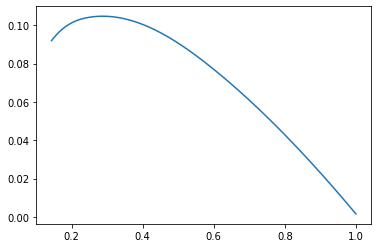

In [4]:
plt.plot(data[0][:,0],data[0][:,1])
plt.show()

In [3]:
D = data.reshape(-1, 2)
mu = D.mean(0)
sigma = D.std(0)

N_train = 1000
P_train = data.shape[1]
Q_train = 500

dom_coords = np.array([[-3, -3],
                       [3,  3]])

u_train_list = []
y_train_list = []
s_train_list = []

u_r_train_list = []
y_r_train_list = []
s_r_train_list = []

# Random key
np.random.seed(1234)

# Create the training data 
for k in range(N_train):
  # Create training data for bcs loss
  u = (data[k] - mu) / sigma  # normalize data
  u_train = np.tile(u.flatten(), (P_train, 1))  # shape = (P_train, 2 * P_train)

  u_train_list.append(u_train)
  y_train_list.append(u)
  s_train_list.append(np.zeros((P_train, 1)))

  # crate training data for physical loss
  u_r = np.tile(u.flatten(), (Q_train, 1))  # shape = (Q_train, 2 * P_train)
  y_r = dom_coords.min(0) + (dom_coords.max(0) - dom_coords.min(0)) * np.random.uniform(size=(Q_train, 2))
  u_r_train_list.append(u_r)
  y_r_train_list.append(y_r)
  s_r_train_list.append(np.ones((Q_train, 1)))

u_train = np.vstack(u_train_list)
y_train = np.vstack(y_train_list)
s_train = np.vstack(s_train_list)

u_r_train = np.vstack(u_r_train_list)
y_r_train = np.vstack(y_r_train_list)
s_r_train = np.vstack(s_r_train_list)
print(u_train.shape,y_train.shape,s_train.shape,u_r_train.shape,y_r_train.shape,s_r_train.shape)

(100000, 200) (100000, 2) (100000, 1) (500000, 200) (500000, 2) (500000, 1)


In [4]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        
        s = torch.sum(branch_output * trunk_output, axis=1)
        return s.view(-1,1)

In [5]:
def Res_loss(u_r, y1, y2, s_r):
    s_pred = model(u_r, torch.hstack((y1,y2)))
    s_y1 = torch.autograd.grad(s_pred, y1, torch.ones_like(s_pred), retain_graph=True, create_graph=True)[0]
    s_y2 = torch.autograd.grad(s_pred, y2, torch.ones_like(s_pred), retain_graph=True, create_graph=True)[0]
    f = s_y1**2 + s_y2**2 - 1
    return torch.mean(f**2)
    
def Bcs_loss(u, y, s):
    s_pred = model(u, y)
    return torch.mean(s_pred**2)

def Loss(u, y, s, u_r, y_r, s_r):
    y1 = y_r[:,0].reshape(-1,1)
    y2 = y_r[:,1].reshape(-1,1)
    res_loss = Res_loss(u_r, y1, y2, s_r)
    bcs_loss = Bcs_loss(u, y, s)
    loss = res_loss + bcs_loss
    return loss, res_loss, bcs_loss

def get_data(u, y, s, u_r, y_r, s_r, batch_size=10000, batch_size_r=10000):
    indices = torch.randint(0, u.size(0), (batch_size,))
    indices_r = torch.randint(0, u_r.size(0), (batch_size_r,))
    u = u[indices,:]
    y = y[indices,:]
    s = s[indices,:]
    u_r = u_r[indices_r,:]
    y_r = y_r[indices_r,:]
    s_r = s_r[indices_r,:]
    return u, y, s, u_r, y_r, s_r

[Epoch 1/2000] [loss: 4.315546035766602]
[Epoch 101/2000] [loss: 1.3456515073776245]
[Epoch 201/2000] [loss: 0.8910576701164246]
[Epoch 301/2000] [loss: 0.7273108959197998]
[Epoch 401/2000] [loss: 0.584951639175415]
[Epoch 501/2000] [loss: 0.5580071210861206]
[Epoch 601/2000] [loss: 0.5228941440582275]
[Epoch 701/2000] [loss: 0.4671890139579773]
[Epoch 801/2000] [loss: 0.44749361276626587]
[Epoch 901/2000] [loss: 0.43203604221343994]
[Epoch 1001/2000] [loss: 0.4186515808105469]
[Epoch 1101/2000] [loss: 0.4013140797615051]
[Epoch 1201/2000] [loss: 0.39476585388183594]
[Epoch 1301/2000] [loss: 0.38631150126457214]
[Epoch 1401/2000] [loss: 0.37484878301620483]
[Epoch 1501/2000] [loss: 0.37177523970603943]
[Epoch 1601/2000] [loss: 0.3655472695827484]
[Epoch 1701/2000] [loss: 0.3656615912914276]
[Epoch 1801/2000] [loss: 0.35758453607559204]
[Epoch 1901/2000] [loss: 0.35630735754966736]


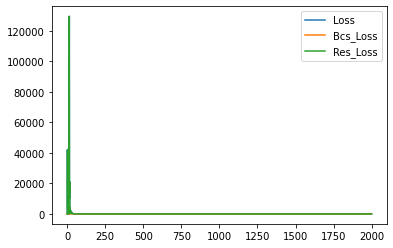

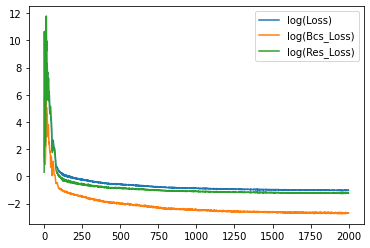

In [6]:
u = torch.tensor(u_train, dtype=torch.float32, requires_grad=True)
y = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
s = torch.tensor(s_train, dtype=torch.float32, requires_grad=True)
u_r = torch.tensor(u_r_train, dtype=torch.float32, requires_grad=True)
y_r = torch.tensor(y_r_train, dtype=torch.float32, requires_grad=True)
s_r = torch.tensor(s_r_train, dtype=torch.float32, requires_grad=True)


model = DeepONet(2 * P_train, 2, 100, 100)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.5)
epochs = 2000
Losses = []
Res_Loss = []
Bcs_Loss = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    loss, res_loss, bcs_loss = Loss(*get_data(u, y, s, u_r, y_r, s_r))
    loss.backward()
    
    if epoch % 100 == 0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        
    Losses.append(loss.item())
    Res_Loss.append(res_loss.item())
    Bcs_Loss.append(bcs_loss.item())
    optimizer.step()
    scheduler.step()
plt.plot(Losses, label = 'Loss')
plt.plot(Bcs_Loss, label = 'Bcs_Loss')
plt.plot(Res_Loss, label = 'Res_Loss')
plt.legend()
plt.show()
plt.plot(np.log(Losses), label = 'log(Loss)')
plt.plot(np.log(Bcs_Loss), label = 'log(Bcs_Loss)')
plt.plot(np.log(Res_Loss), label = 'log(Res_Loss)')
plt.legend()
plt.show()

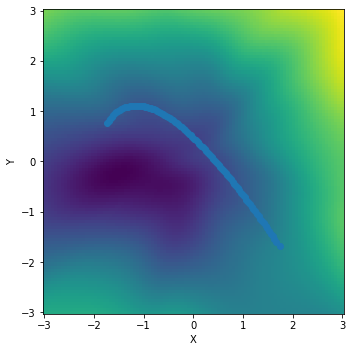

In [11]:
xx = np.linspace(-3,3,100)
yy = np.linspace(-3,3,100)
X, Y = np.meshgrid(xx, yy)
y_test = torch.tensor(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), dtype = torch.float32)
idx = 0
s_pre = model(u[idx,:].reshape(1,-1), y_test).detach().numpy()

fig = plt.figure(figsize=(5,5))
plt.pcolor(xx, yy, s_pre.reshape(100,100))
plt.scatter(u[idx,:][::2].detach().numpy(),u[idx,:][1::2].detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()